# Modeling Competing Contagions on Small-World Networks
### Extension of 'Complex Contagions and the Weakness of Long Ties'
**Goal**: Simulate and analyze how two contagions (A and B) spread simultaneously across a rewired lattice network.
Explore their interaction and how network structure (rewiring probability) impacts propagation speed and final adoption rates.

## 1. Model Description
We simulate two competing contagions, A and B. Each node can adopt one or both contagions depending on predefined rules.

**Key model features:**
- **Network**: Watts-Strogatz small-world network
- **Contagion Rule**: A node adopts contagion A (or B) if enough of its neighbors have adopted A (or B), based on respective thresholds
- **Competition Rule**: A node may adopt:
  - Only one contagion (exclusive)
  - Or both (non-exclusive)
- **Initial Conditions**: A few nodes are seeded with contagion A and B
- **Metrics Tracked**: Propagation over time, adoption percentages, time to saturation

## 2. Imports and Setup

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

## 3. Network Generation

In [2]:
def create_small_world(N, k, p):
    return nx.watts_strogatz_graph(N, k, p)

## 4. Simulation Logic

In [3]:
# This is a placeholder function – we will extend it next
def simulate_two_contagions(G, seed_A, seed_B, theta_A, theta_B, max_steps=100, exclusive=True):
    '''
    Simulate contagion spread for two contagions on graph G.
    '''
    N = G.number_of_nodes()
    status = {n: set() for n in G.nodes()}
    for n in seed_A:
        status[n].add('A')
    for n in seed_B:
        status[n].add('B')

    history_A = []
    history_B = []

    for step in range(max_steps):
        new_status = {n: set(status[n]) for n in G.nodes()}
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            infected_A = sum(['A' in status[neigh] for neigh in neighbors]) / len(neighbors)
            infected_B = sum(['B' in status[neigh] for neigh in neighbors]) / len(neighbors)

            if 'A' not in status[node] and infected_A >= theta_A:
                if exclusive and 'B' in status[node]:
                    continue
                new_status[node].add('A')
            if 'B' not in status[node] and infected_B >= theta_B:
                if exclusive and 'A' in status[node]:
                    continue
                new_status[node].add('B')

        status = new_status
        history_A.append(sum(['A' in s for s in status.values()]) / N)
        history_B.append(sum(['B' in s for s in status.values()]) / N)

        if history_A[-1] + history_B[-1] >= 0.99:
            break

    return history_A, history_B

## 5. Example Run

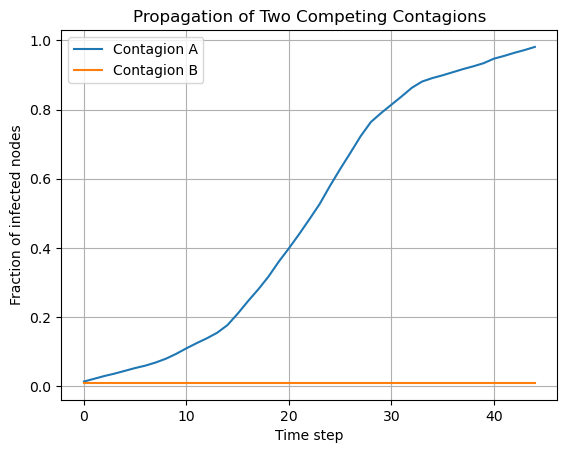

In [4]:
N = 1000
k = 10
p = 0.05
theta_A = 0.2
theta_B = 0.3
G = create_small_world(N, k, p)

seed_A = random.sample(list(G.nodes()), 10)
seed_B = random.sample(list(set(G.nodes()) - set(seed_A)), 10)

hist_A, hist_B = simulate_two_contagions(G, seed_A, seed_B, theta_A, theta_B, exclusive=True)

# Plotting
plt.plot(hist_A, label='Contagion A')
plt.plot(hist_B, label='Contagion B')
plt.xlabel('Time step')
plt.ylabel('Fraction of infected nodes')
plt.title('Propagation of Two Competing Contagions')
plt.legend()
plt.grid(True)
plt.show()

## 6. Batch Simulations Across Rewiring Probabilities
To study how network randomness (rewiring probability `p`) affects the competition between contagions A and B, we run simulations over a range of `p` values. We track the final adoption fractions of each contagion and analyze which one dominates under different structural settings.

In [5]:
import numpy as np
import random
from tqdm import tqdm

def run_batch_simulations(N, k, ps, theta_A, theta_B, seed_size=10, exclusive=True, runs_per_p=5):
    results = []
    for p in tqdm(ps):
        final_A = []
        final_B = []
        for _ in range(runs_per_p):
            G = nx.watts_strogatz_graph(N, k, p)
            nodes = list(G.nodes())
            seed_A = random.sample(nodes, seed_size)
            seed_B = random.sample(list(set(nodes) - set(seed_A)), seed_size)

            hist_A, hist_B = simulate_two_contagions(G, seed_A, seed_B, theta_A, theta_B, exclusive=exclusive)
            final_A.append(hist_A[-1])
            final_B.append(hist_B[-1])

        results.append({
            'p': p,
            'A_mean': np.mean(final_A),
            'B_mean': np.mean(final_B),
            'A_std': np.std(final_A),
            'B_std': np.std(final_B)
        })
    return results

In [11]:
# Run batch simulations for exclusive adoption
ps = np.linspace(0, 0.3, 10)
results_exclusive = run_batch_simulations(N=1000, k=10, ps=ps, theta_A=0.2, theta_B=0.3, seed_size=10, exclusive=True, runs_per_p=5)
#plot_batch_results(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


To understand how allowing nodes to adopt **both contagions** affects the dynamics, we now repeat the simulation with `exclusive=False`. This allows individuals to adopt both contagions if both thresholds are reached. We compare the final adoption rates under exclusive vs. non-exclusive rules.

In [9]:
# Run batch simulations for non-exclusive adoption
results_non_exclusive = run_batch_simulations(N=1000, k=10, ps=ps, theta_A=0.2, theta_B=0.3, seed_size=10, exclusive=False, runs_per_p=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]


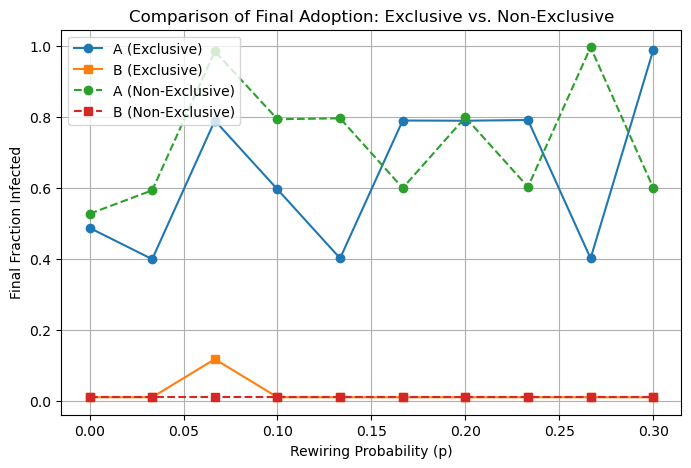

In [12]:
# Extract means from both sets of results
A_ex = [r['A_mean'] for r in results_exclusive]
B_ex = [r['B_mean'] for r in results_exclusive]
A_non = [r['A_mean'] for r in results_non_exclusive]
B_non = [r['B_mean'] for r in results_non_exclusive]

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(ps, A_ex, label='A (Exclusive)', marker='o', linestyle='-')
plt.plot(ps, B_ex, label='B (Exclusive)', marker='s', linestyle='-')
plt.plot(ps, A_non, label='A (Non-Exclusive)', marker='o', linestyle='--')
plt.plot(ps, B_non, label='B (Non-Exclusive)', marker='s', linestyle='--')
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Final Fraction Infected')
plt.title('Comparison of Final Adoption: Exclusive vs. Non-Exclusive')
plt.legend()
plt.grid(True)
plt.show()